In [1]:
# Basic functions
from knn_chain import knn_chain
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt
import json

# Importing inputs
from exp_setup import n, all_ks, linear_ks, s_X, med_X, large_X, xl_X, xxl_X, y_train, x_train, mnist_data, bbc_matrix, adult, dataset_sizes_syn, dataset_sizes_real
from exp_setup import syn_titles, real_titles, classes, colours, optimal_ds, opt_timings

# Importing plotting
from exp_setup import plot_runtimes, plot_all_runtimes, plot_comparison, plot_mem

2024-10-02 16:38:27.992577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 16:38:27.993836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 16:38:27.998398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 16:38:28.007459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 16:38:28.018869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

- Get all experiment outputs

In [2]:
with open('exp_output.json', 'r') as f:
    experiments = json.load(f)

In [3]:
times = experiments['time']
memories = experiments['memory']

In [4]:
all_syn_avgs = [times['avgs_small_gen'], times['avgs_med_gen'], times['avgs_large_gen'], times['avgs_xl_gen'], times['avgs_xxl_gen']]
all_real_avgs = [times['avgs_mnist'], times['avgs_bbc'], times['avgs_adult']]


all_syn_mems = [memories['s_mem'], memories['med_mem'], memories['large_mem'], memories['xl_mem'], memories['xxl_mem']]
all_real_mems = [memories['mnist_mem'], memories['bbc_mem'], memories['adult_mem']]
syn_knn_mems = [x[0] for x in all_syn_mems]
real_knn_mems = [x[0] for x in all_real_mems]

# Dataset Visualisation

## 1. Synthetic Dataset

## 2. Real Dataset

- MNIST

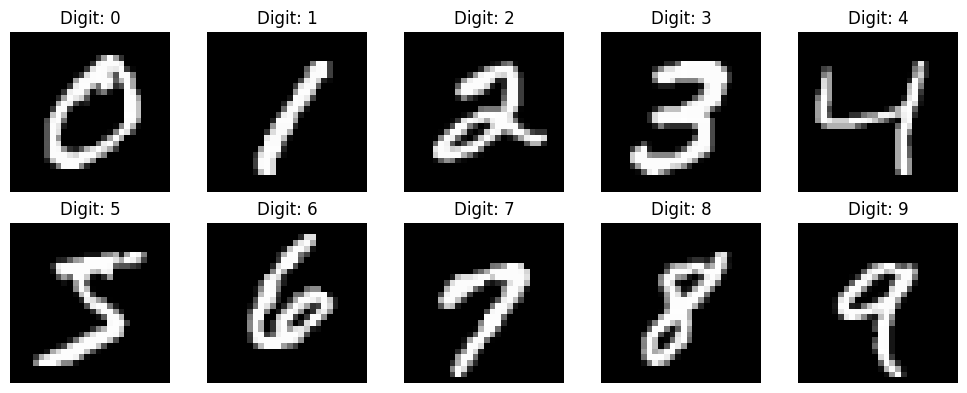

In [7]:
plt.figure(figsize=(10, 4))

for digit in range(10):
    index = (y_train == digit).nonzero()[0][0]
    plt.subplot(2, 5, digit + 1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(f'Digit: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()

- BBC News

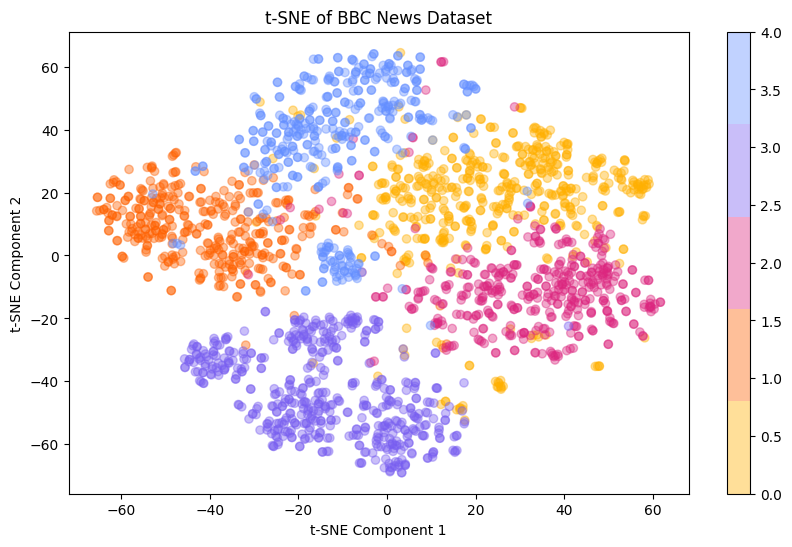

In [48]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(bbc_tsne[:, 0], bbc_tsne[:, 1], c=classes, cmap=colours, alpha=0.4)
plt.colorbar(scatter)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of BBC News Dataset')
plt.show()

# WHAT DO DO ABOUT ADULT ?

# Runtime complexity

## 1. Synthetic 

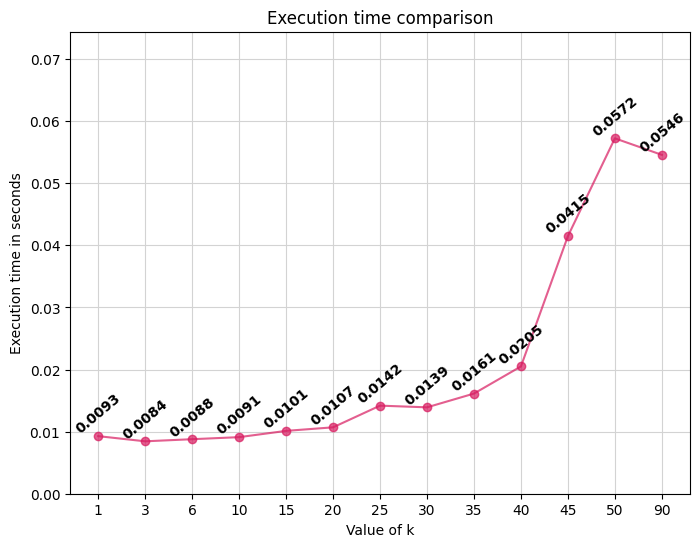

In [3]:
# 1 000 x 2
plot_runtimes(all_ks, times['avgs_small_gen'])

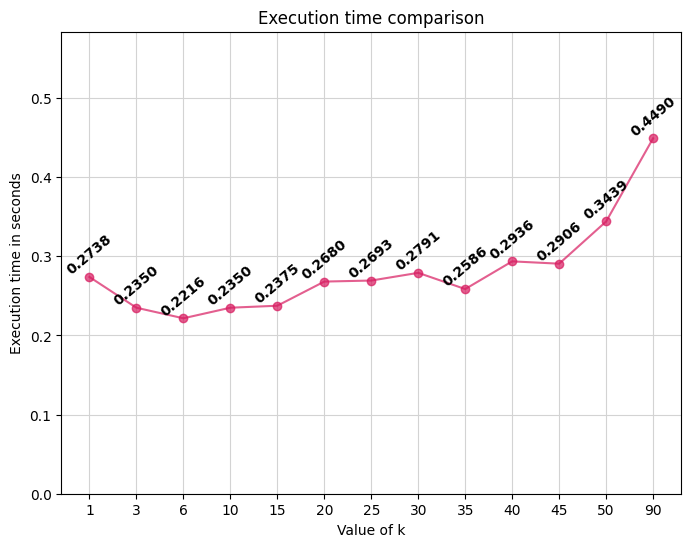

In [4]:
# 5 000 x 5
plot_runtimes(all_ks, times['avgs_med_gen'])

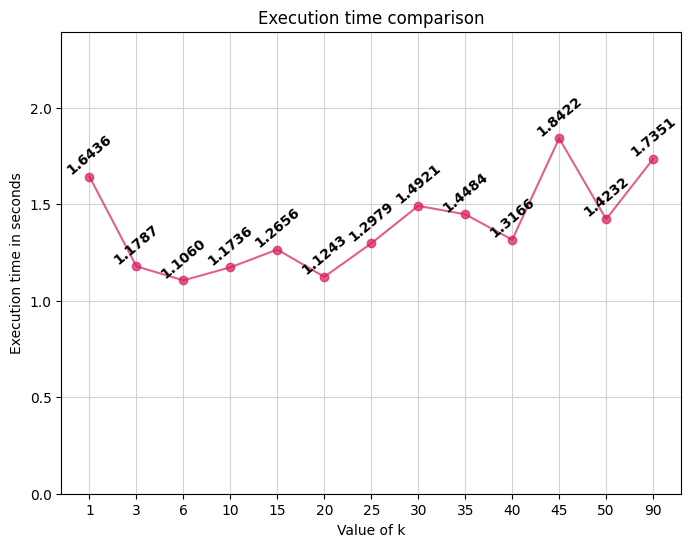

In [5]:
# 10 000 x 10
plot_runtimes(all_ks, times['avgs_large_gen'])

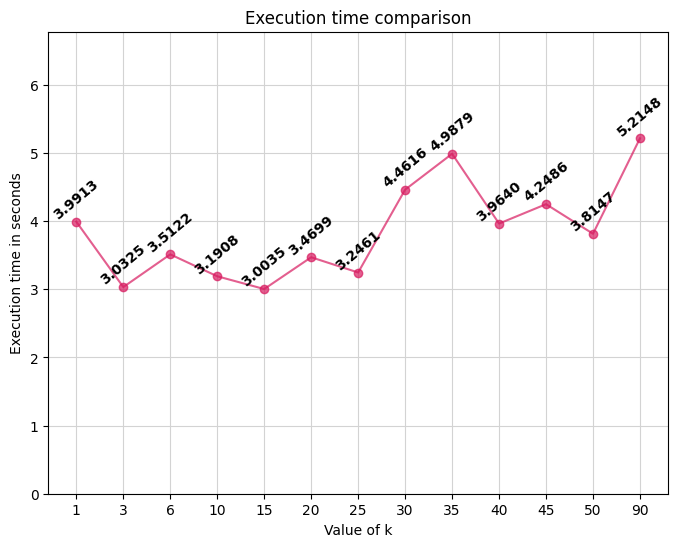

In [6]:
# 15 000 x 10
plot_runtimes(all_ks, times['avgs_xl_gen'])

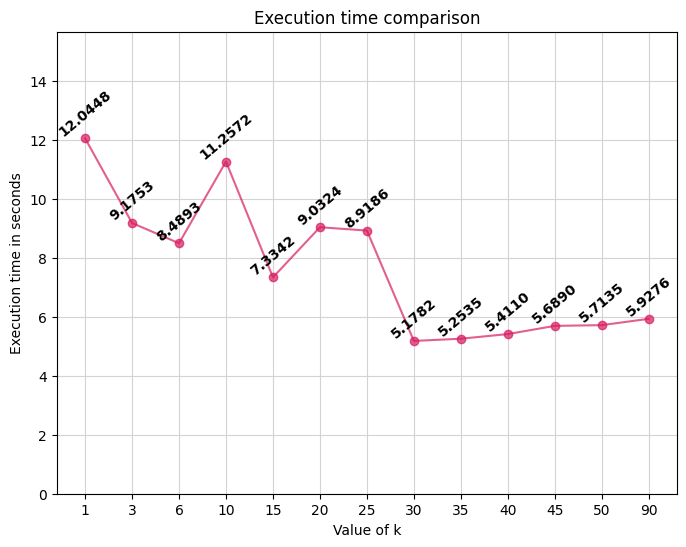

In [7]:
# 20 000 x 15
plot_runtimes(all_ks, times['avgs_xxl_gen'])

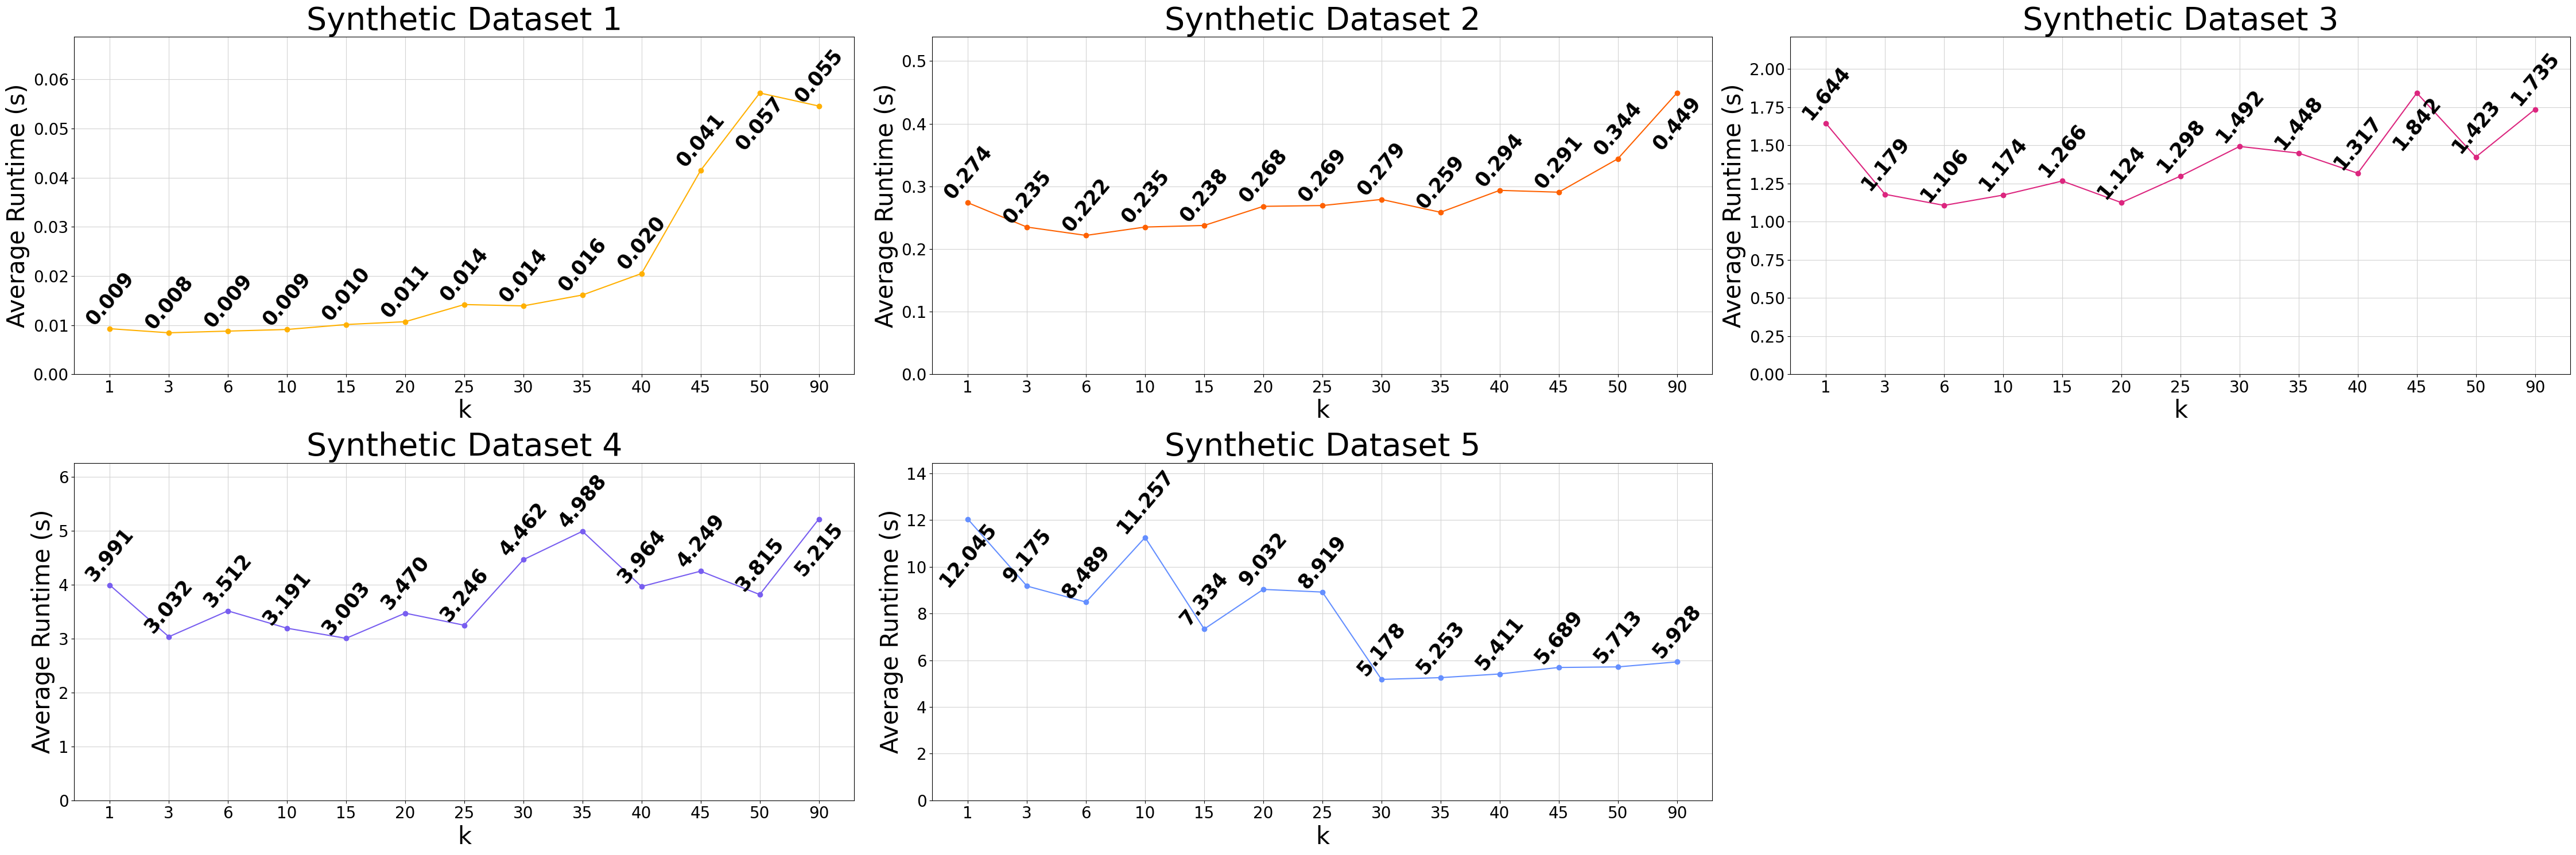

In [6]:
# Plotting all runtime together
label_indices = [len(all_syn_avgs[0])-2, len(all_syn_avgs[1])-1, len(all_syn_avgs[2])-3, len(all_syn_avgs[3])-1,0]
plot_all_runtimes(all_syn_avgs, all_ks, syn_titles, label_indices)

In [9]:
import seaborn.objects as so
import seaborn as sns
import pandas as pd

In [14]:
x = pd.DataFrame(all_syn_avgs + all_real_avgs, columns=[str(k) for k in all_ks])
x['name'] = ['sds 1', 'sds 2', 'sds 3', 'sds 4', 'sds 5', 'MNIST', 'BBC News', 'Adult']
df_long = x.melt(id_vars=['name'], var_name='k', value_name='Runtime', ignore_index=False).reset_index()

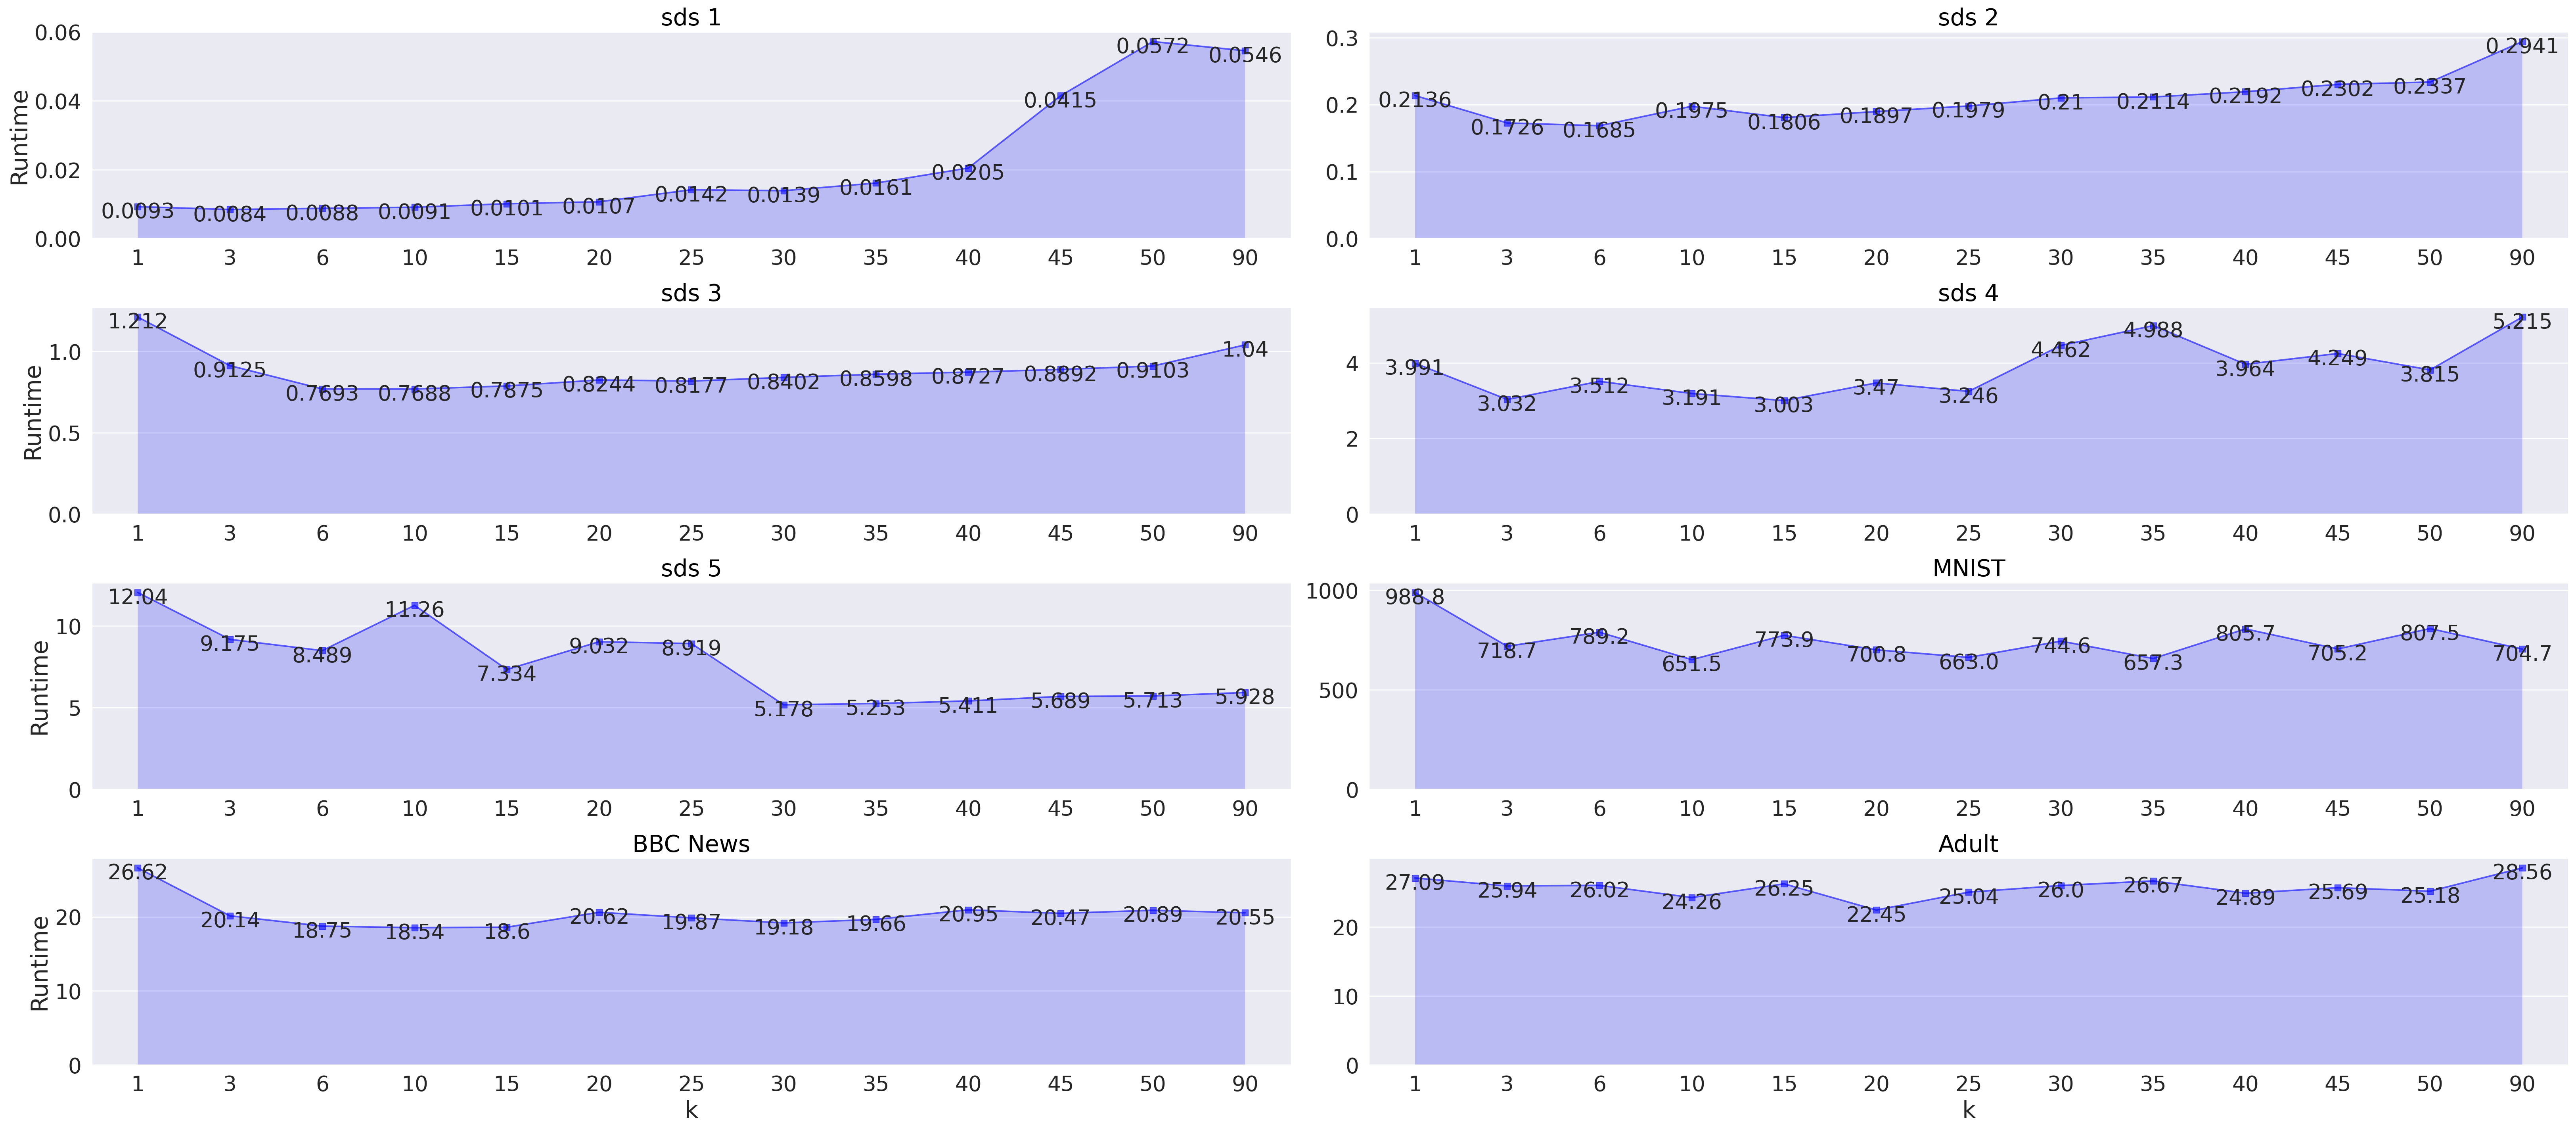

In [16]:
def custom_round(val):
    if val < 1:
        return round(val, 4)
    elif val <= 10:
        return round(val, 3)
    elif val > 10 and val < 100:
        return round(val, 2)
    else:
        return round(val, 1)

p = (
    so.Plot(data = df_long, x = 'k', y = 'Runtime', text=df_long['Runtime'].apply(custom_round))
    .layout(size=(34, 15))
    .facet("name", wrap = 2)
    .share(x=False, y=False)
    .theme({
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'axes.labelsize': 22,
        'axes.titlesize': 22,
    })
)
(
    p.add(so.Area(edgewidth=0, alpha=0.2, color = 'blue'), legend=False)
    .add(so.Line(edgewidth=3, alpha=0.6, color =  'blue'), legend=False)
    .add(so.Dot(marker = 's', alpha=0.6, color =  'blue'), legend=False)
    .add(so.Text(valign="bottom", offset=-15, fontsize=20), legend=False)
)

## 2. Real 

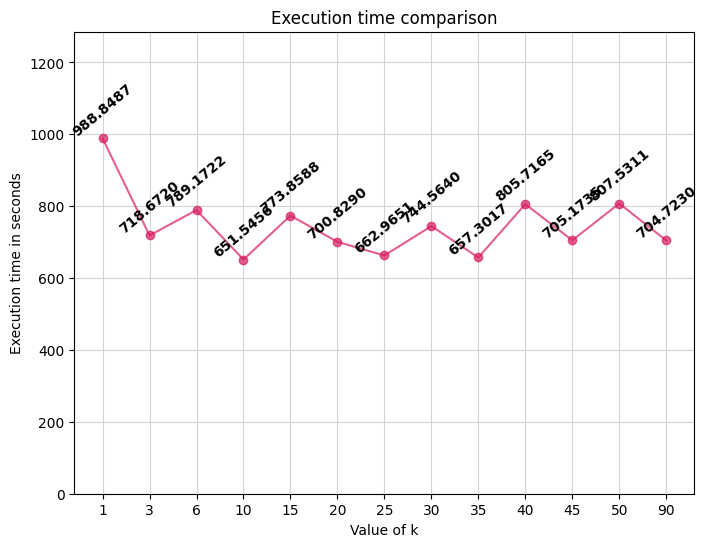

In [9]:
# MNIST
plot_runtimes(all_ks, times['avgs_mnist'])

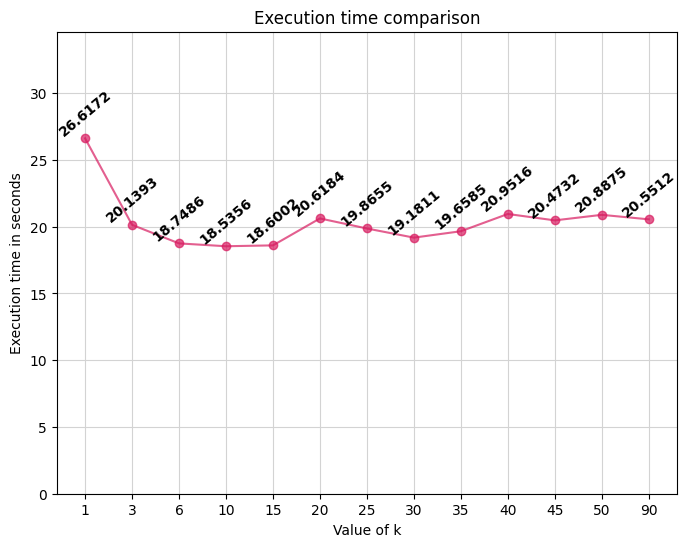

In [13]:
# BBC News
plot_runtimes(all_ks, times['avgs_bbc'])

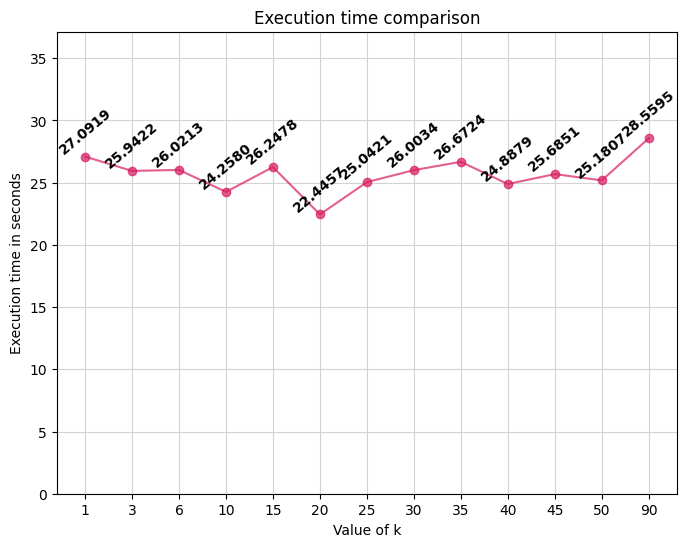

In [11]:
# Adult
plot_runtimes(all_ks, times['avgs_adult'])

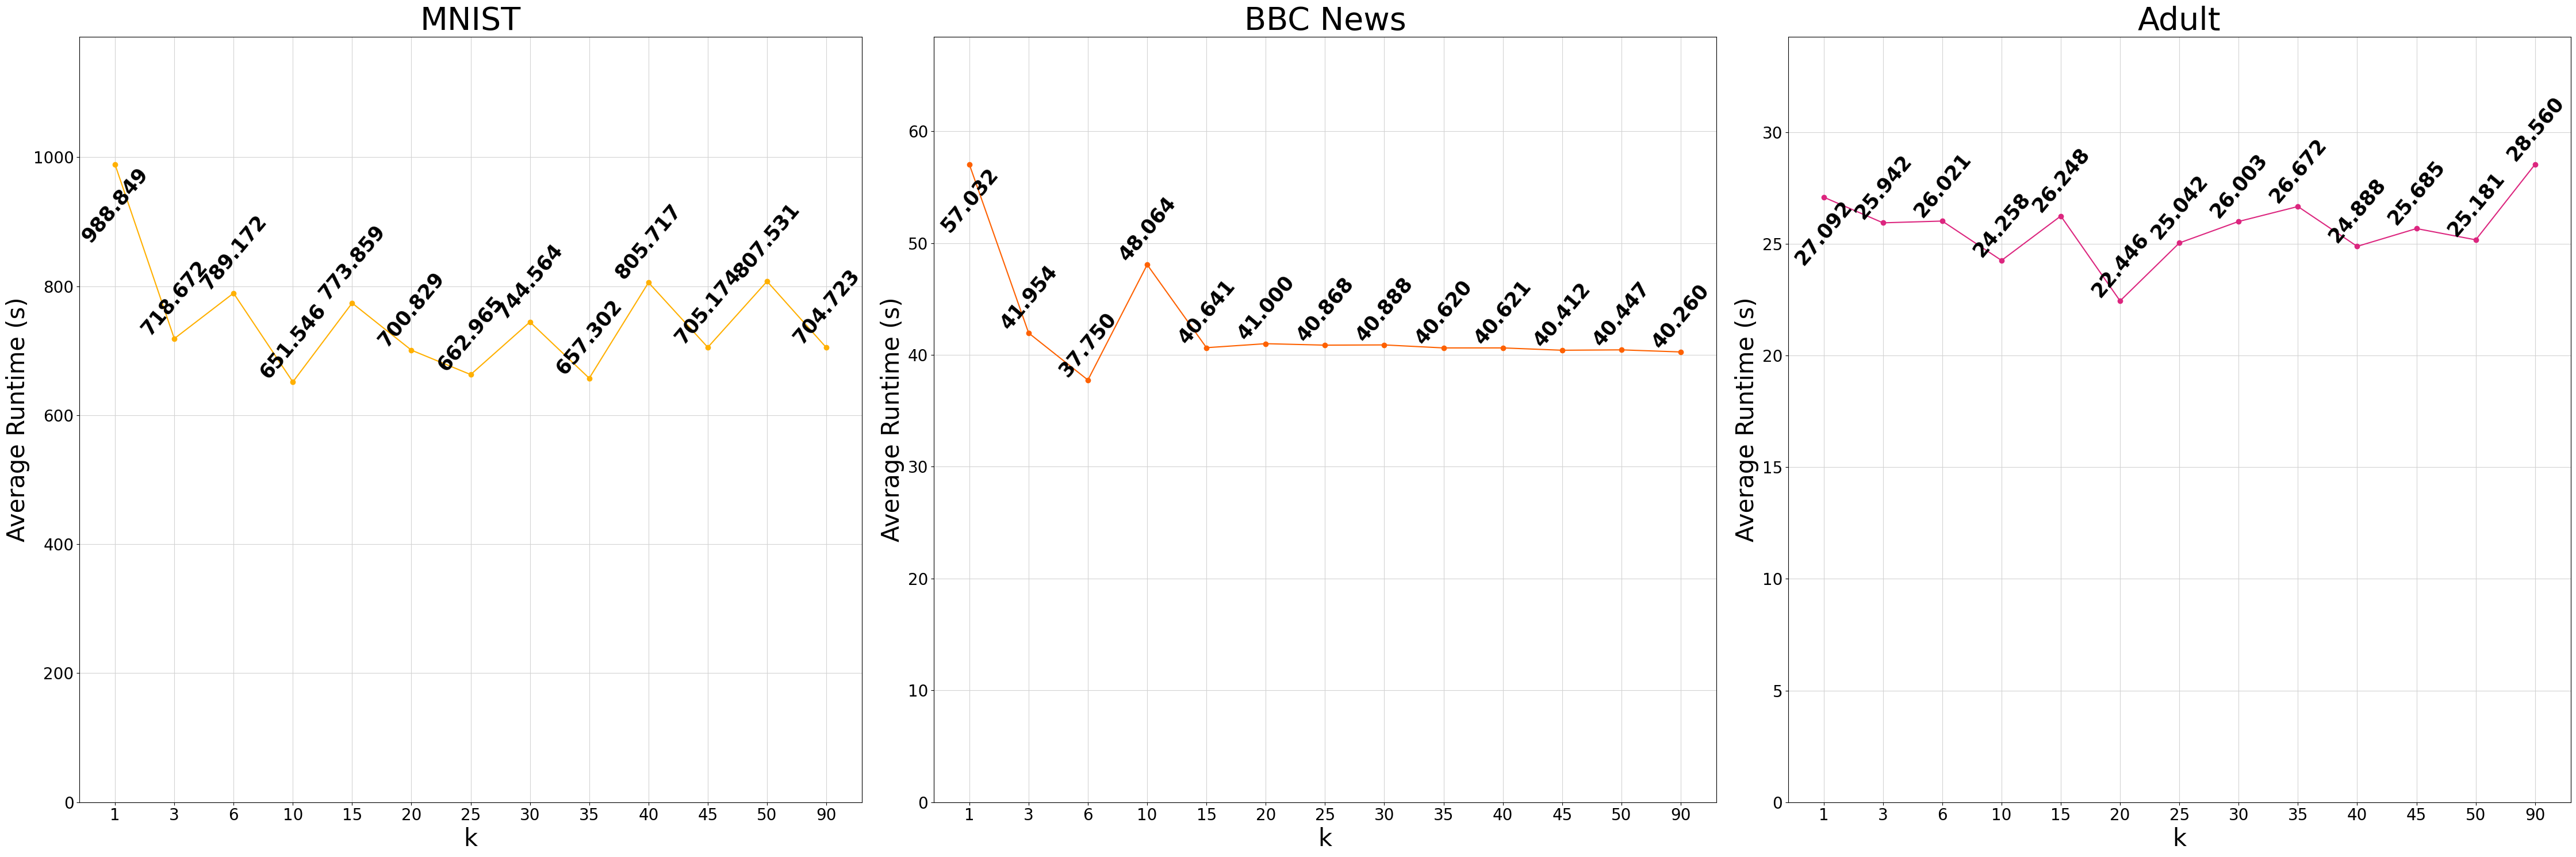

In [12]:
label_indices = [0,0,0]
plot_all_runtimes(all_real_avgs, all_ks, real_titles, label_indices)

## 3. Compare Runtime to NN Chain (SciPy)

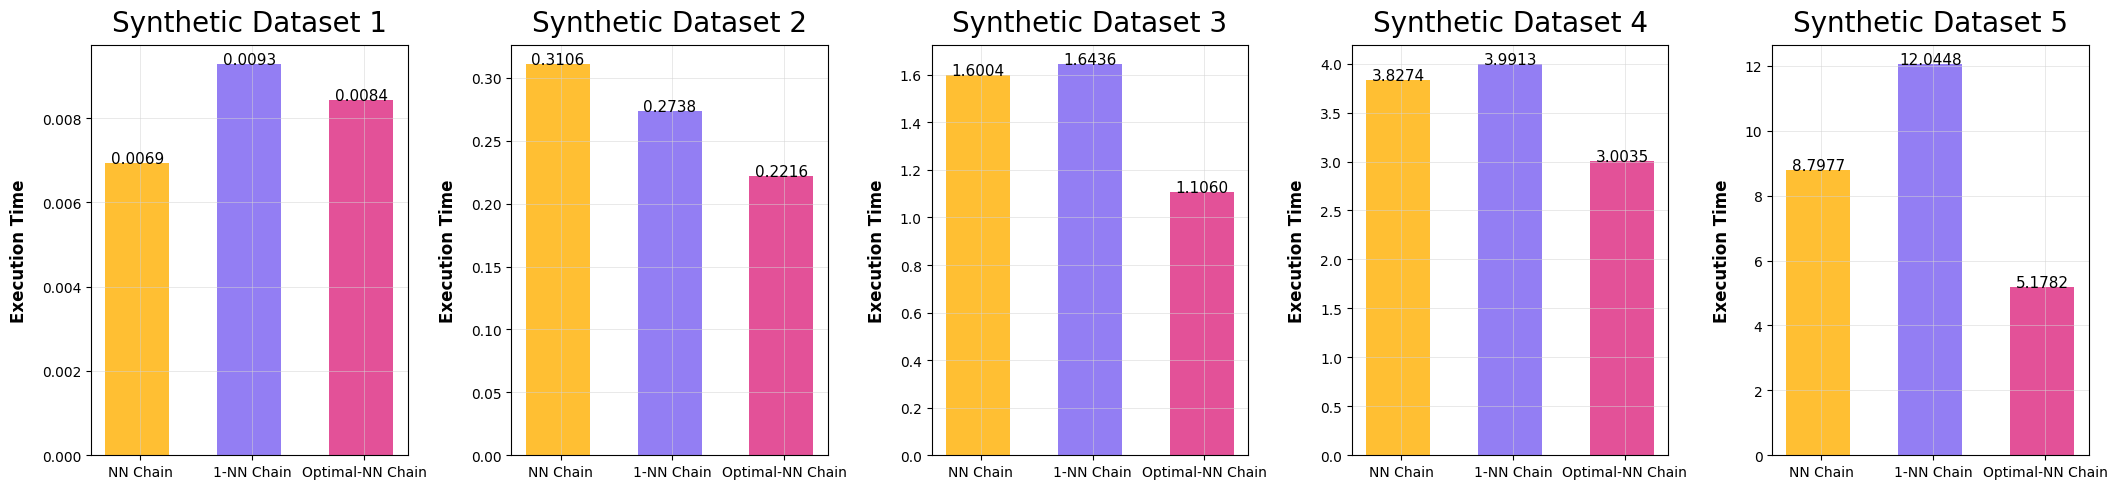

In [12]:
# 1. Synthetic Data
best_knn = [min(x) for x in all_syn_avgs]
plot_comparison(syn_nn_time, np.array(all_syn_avgs)[:, 0], best_knn, syn_titles, size=(25, 5))

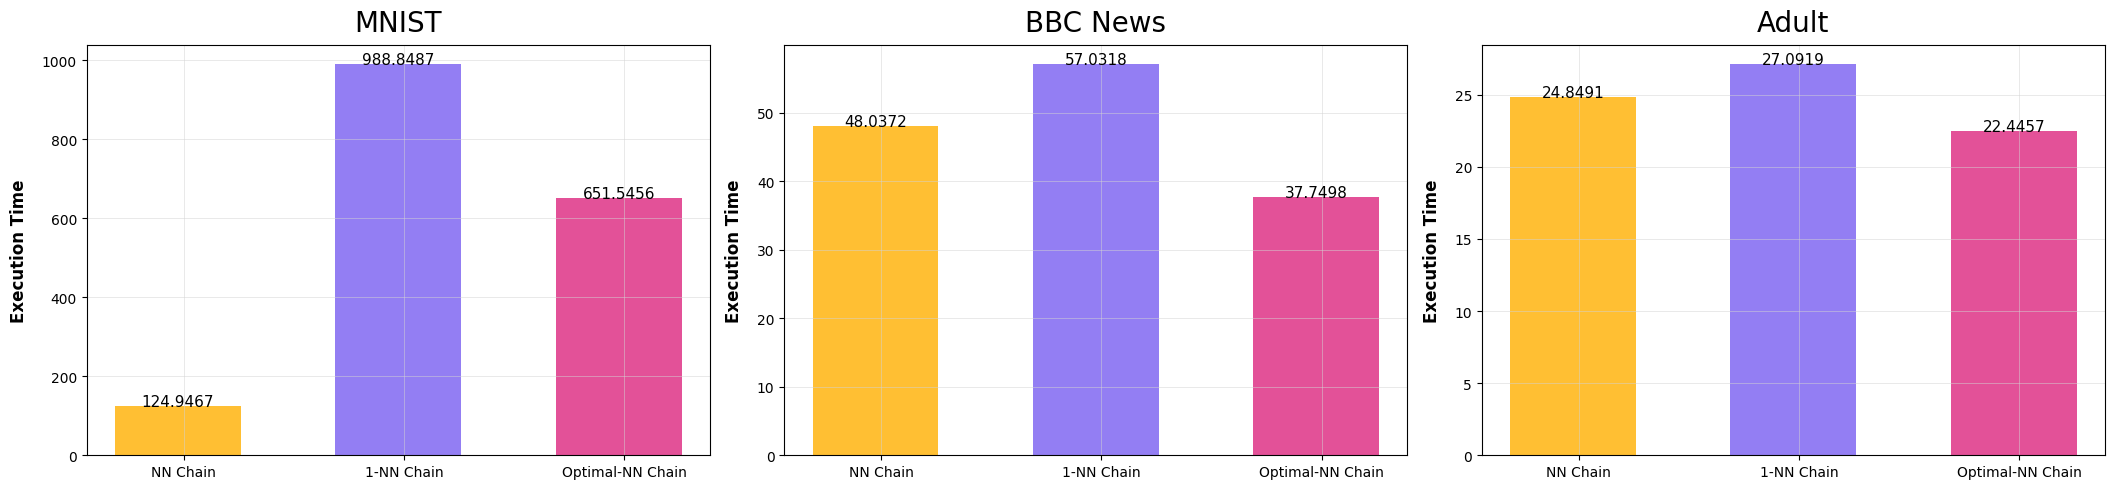

In [13]:
best_real_knn = [min(x) for x in all_real_avgs]
plot_comparison(real_nn_time, np.array(all_real_avgs)[:, 0], best_real_knn, real_titles, size=(25, 5))

# Memory Complexity

1. Synthetic

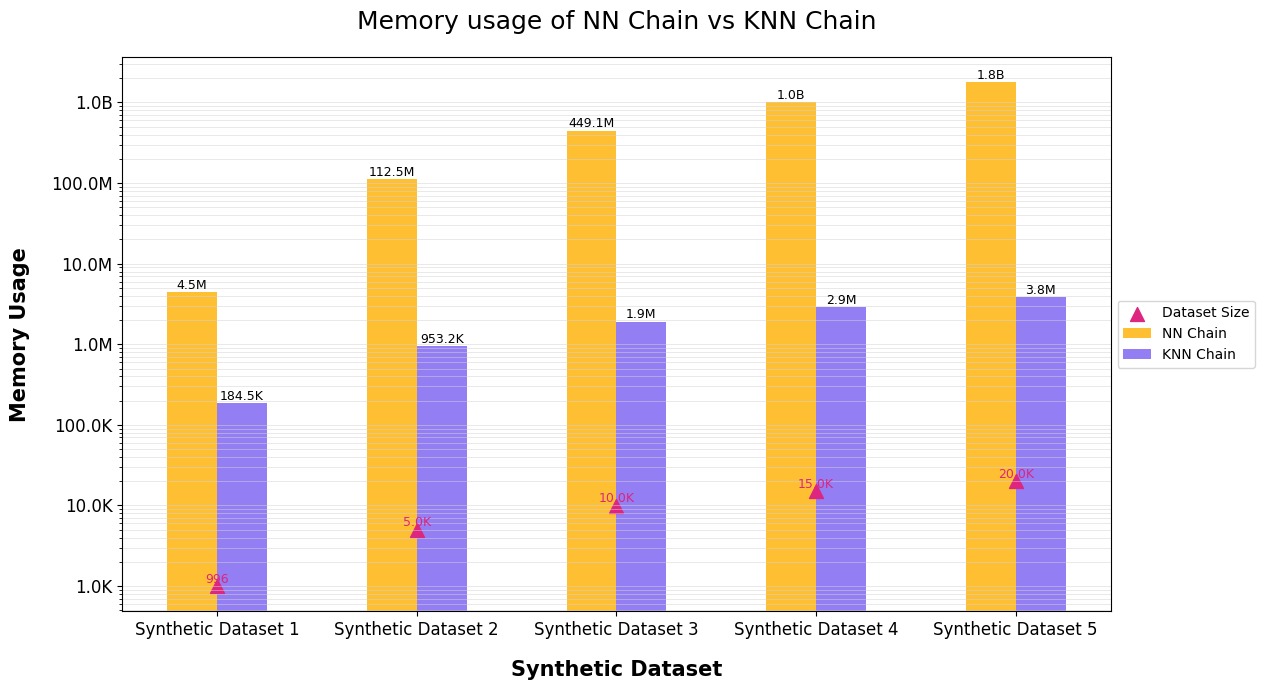

In [17]:
plot_mem(syn_nn_mems, syn_knn_mems, dataset_sizes_syn, 'Synthetic Dataset', syn_titles, (15, 7))

2. Real

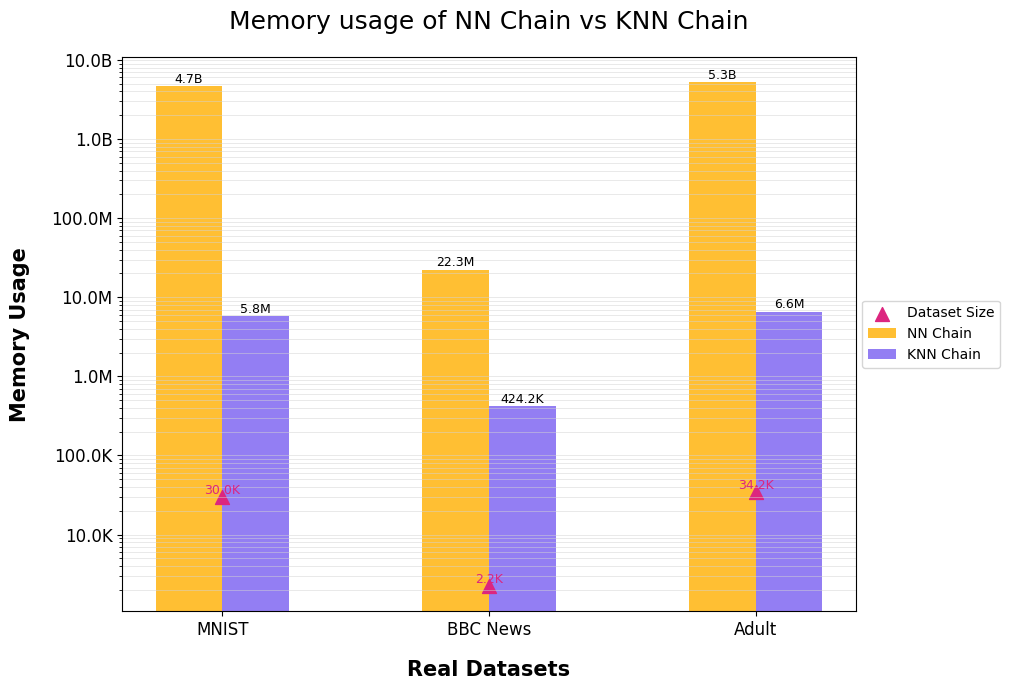

In [18]:
plot_mem(real_nn_mems, real_knn_mems, dataset_sizes_real, 'Real Datasets', real_titles, (12,7))

3. all

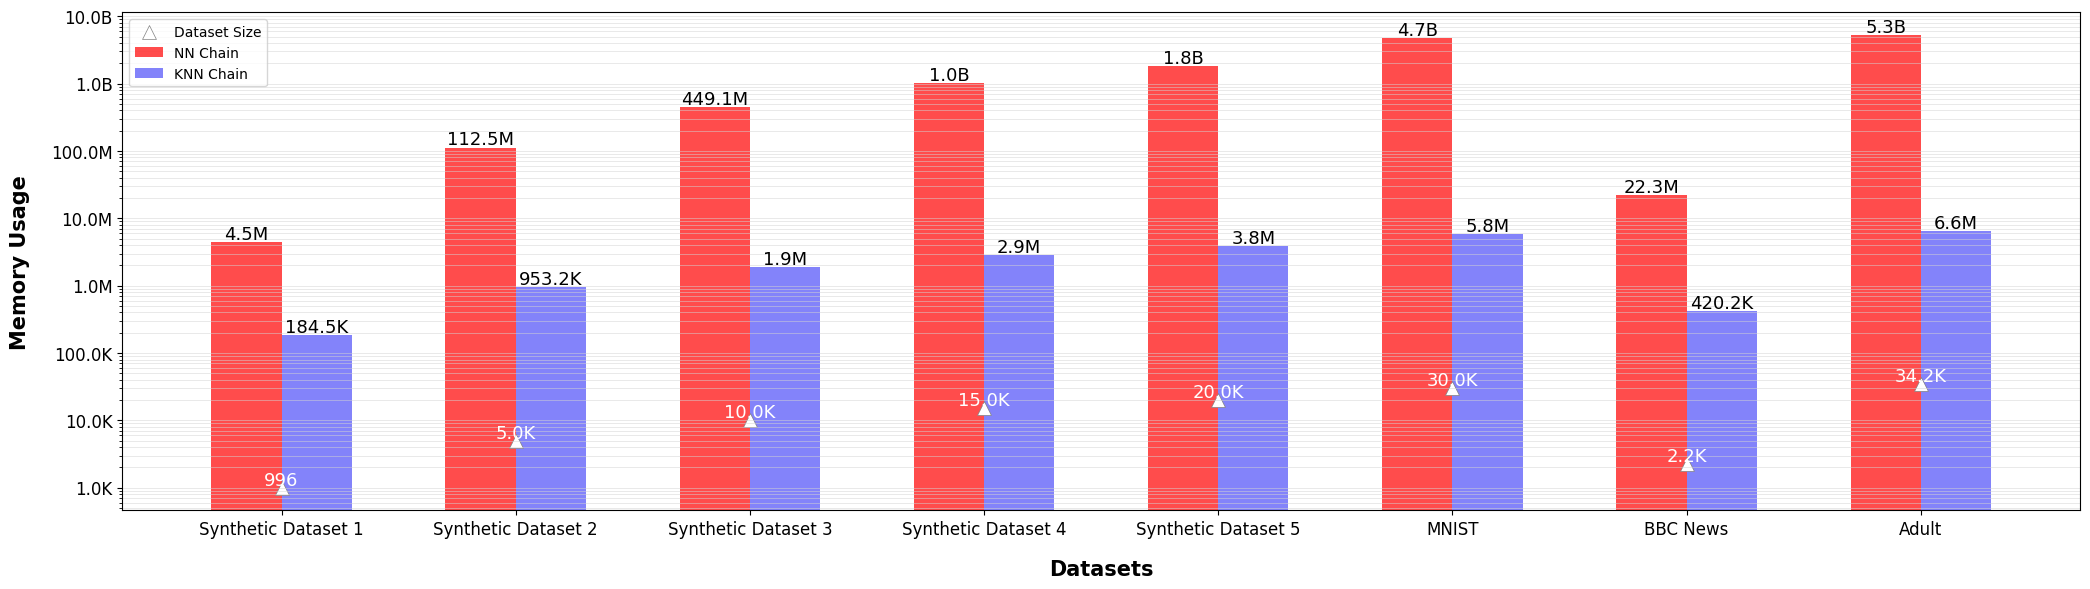

In [5]:
plot_mem(memories['syn_nn_mems'] + memories['real_nn_mems'], syn_knn_mems + real_knn_mems, dataset_sizes_syn + dataset_sizes_real, 'Datasets', syn_titles+real_titles, (21, 6))

# Optimal k

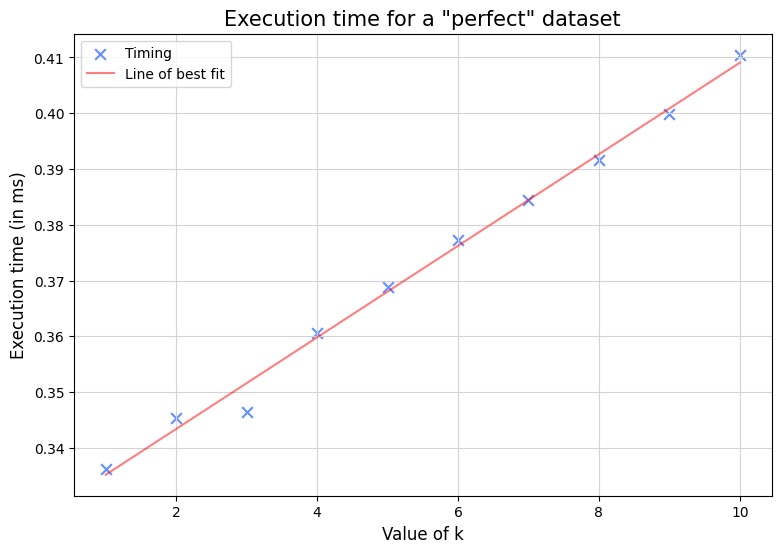

In [19]:
slope, intercept = np.polyfit(linear_ks, opt_timings, 1)
fit_line = np.polyval([slope, intercept], linear_ks)

plt.figure(figsize=(9, 6))

plt.scatter(linear_ks, opt_timings , s = 60, c = "#648FFF" , marker = "x", label = "Timing")
plt.plot(linear_ks, fit_line, linewidth=1.5, color="r", alpha=0.5, label = "Line of best fit")

plt.title('Execution time for a "perfect" dataset', fontsize=15)
plt.xlabel("Value of k", fontsize=12)
plt.ylabel("Execution time (in ms)", fontsize=12)
plt.grid(c="#d3d3d3")
plt.legend()

plt.show()

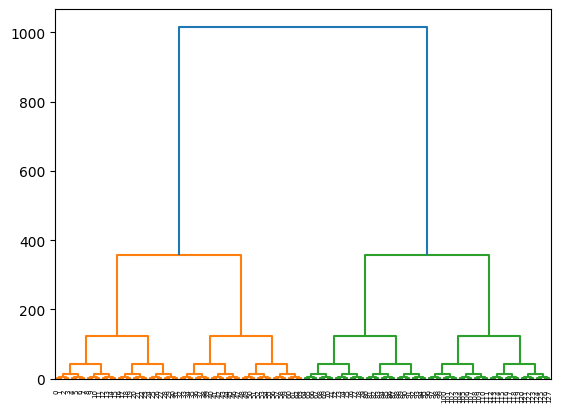

In [20]:
z = knn_chain(optimal_ds, 1)
dendrogram(z)
plt.show()